### Gold Fish Lifespan.

In this notebook we are going to create a machine learning model that will be able to predict life span of gold fishes to farmers using the  `Gold Fish Lifespan` dataset that was obtained on kaggle [`Gold Fish Lifespan`](https://www.kaggle.com/datasets/stealthtechnologies/predict-lifespan-of-a-comet-goldfish).

> https://www.kaggle.com/datasets/stealthtechnologies/predict-lifespan-of-a-comet-goldfish

We are going to evaluate different Machine learning Algorithims not limmited to the following:

1. `DecisionTreeRegressor`
2. `SVR`
3. `RandomForestRegressor`
4. `LinearRegression`
5. `KNeighborsRegressor`

We are going to choose the best algorithm to perform a regression task on predicting the `fish lifespan`.

In the following code cell we are going to install all packages that we are to use in this notebook.

In [1]:
!pip install pigmenta helperfns kaggle -q

### Import of modules

In the following code cell we are going to import all the packages that are going to be used in this notebook.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import random
import os
import json
import sklearn

from joblib import dump
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from helperfns.tables import tabulate_data

from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from matplotlib import pyplot as plt
import xgboost as xgb
from pigmenta import PALETTES

warnings.filterwarnings("ignore")

print("pandas:", pd.__version__)
print("sklearn: ", sklearn.__version__)
print("numpy:", np.__version__)
print("xgb:", xgb.__version__)

pandas: 2.2.2
sklearn:  1.6.1
numpy: 2.0.2
xgb: 3.0.4


### Seed
Next we are going to set the seed for all random operations for reproducivity of results in this notebook.

In [3]:
SEED = 23

np.random.seed(SEED)
random.seed(SEED)

### Data
In the following code cell we are going to define the path to where the data is located.

We are going to use the kaggle API to download the dataset from kaggle.

> https://www.kaggle.com/datasets/stealthtechnologies/predict-lifespan-of-a-comet-goldfish

In [4]:
with open('kaggle.json', 'r') as reader:
  keys = json.loads(reader.read())
  os.environ['KAGGLE_USERNAME'] = keys['username']
  os.environ['KAGGLE_KEY'] = keys['key']
!kaggle datasets download stealthtechnologies/predict-lifespan-of-a-comet-goldfish --unzip

path = "fish_data.csv"

Dataset URL: https://www.kaggle.com/datasets/stealthtechnologies/predict-lifespan-of-a-comet-goldfish
License(s): apache-2.0
  0% 0.00/25.3k [00:00<?, ?B/s]
100% 25.3k/25.3k [00:00<00:00, 107MB/s]


Next we are going to read the data into a pandas dataframe.

In [5]:
data = pd.read_csv(path)
data.head(2)

,id,average_length(inches)),average_weight(inches)),habitat,ph_of_water,color,Gender,life_span
0,1,14.69,5.87,ponds,6.2,Reddish_Orange,False,10.9
1,2,1.32,3.86,idlewater,6.8,Calico,True,5.2


In [6]:
data.drop(columns=["id"], inplace=True)
data.rename(columns = {
    "average_length(inches))": "length", "average_weight(inches))": "weight",
    "ph_of_water": "water_ph", "Gender": "gender", "life_span": "age"
}, inplace=True)

data.gender = data.gender.apply(lambda x: "male" if x == True else "female")
data.color = data.color.apply(lambda x: x.lower())
data.head(2)

,length,weight,habitat,water_ph,color,gender,age
0,14.69,5.87,ponds,6.2,reddish_orange,female,10.9
1,1.32,3.86,idlewater,6.8,calico,male,5.2


In the following code cell we are going to drop all `na` values that might exists in columns of this dataset.

In [7]:
if any(data.isna().any()):
    data.dropna(inplace=True)

### Data Insights
In this section of the notwbook we are going to have a look at some data insights based on the dataset of fish.



First we are going to start by looking at the distribution interms of how the gender of fishes are distributed.

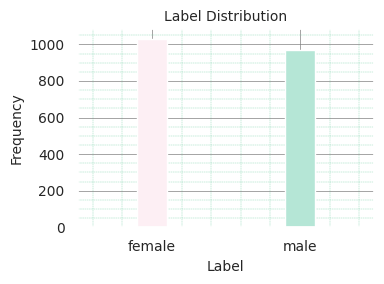

In [8]:
sns.set(font_scale=.8)
sns.set_style("white", rc={"axes.spines.right": True, "axes.spines.top": True})
sns.set(rc={"axes.facecolor": "#FFFFFF", "figure.facecolor": "#FFFFFF"})

plt.figure(figsize=(4, 3))
sns.countplot(data=data, x="gender", palette=PALETTES.gradient, width=0.2)
plt.xlabel("Label", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.title("Label Distribution", fontsize=10)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.tight_layout()
plt.show()

The following plot shows the Scatterplot of Length vs Weight (colored by habitat)

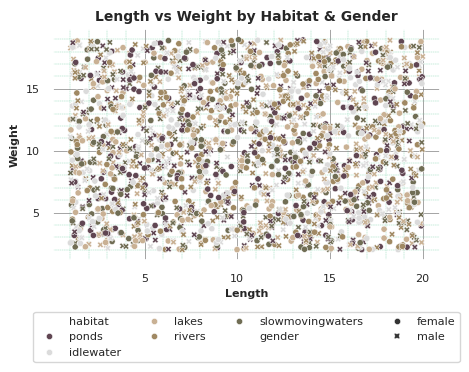

In [9]:
plt.figure(figsize=(5, 3))
sns.scatterplot(data=data, x="length", y="weight", hue="habitat", style="gender", s=20,
                palette=PALETTES.food[55:])
plt.title("Length vs Weight by Habitat & Gender", fontsize=10, weight="bold")
plt.xlabel("Length", fontsize=8, weight="bold")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.2),
    ncol=4,
    fontsize=8,
    title=""
)

plt.ylabel("Weight", fontsize=8, weight="bold")
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.minorticks_on()
plt.show()

The following plot shows the distribution between the age and the habitat of the fish.

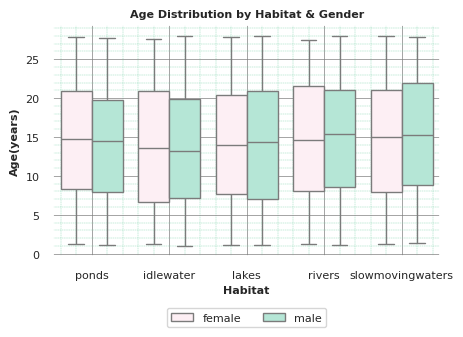

In [10]:
plt.figure(figsize=(5, 3))
sns.boxplot(data=data, x="habitat", y="age", hue="gender", palette=PALETTES.gradient)

plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.2),
    ncol=4,
    fontsize=8,
    title=""
)
plt.title("Age Distribution by Habitat & Gender", fontsize=8, weight="bold")
plt.ylabel("Age(years)", fontsize=8, weight="bold")
plt.xlabel("Habitat", fontsize=8, weight="bold")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.minorticks_on()
plt.show()


The following plot shows the countplot of fish gender coloured by `color`

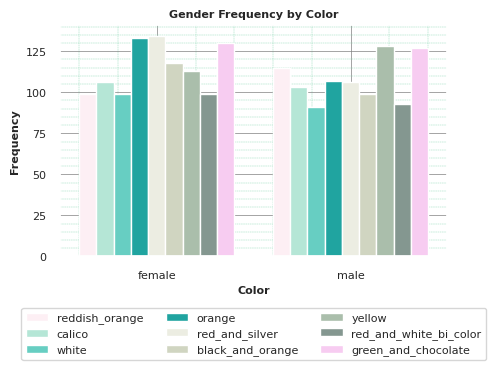

In [11]:
plt.figure(figsize=(5, 3))
sns.countplot(data=data, x="gender", hue="color", palette=PALETTES.gradient)
plt.xticks(rotation=30)

plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.2),
    ncol=3,
    fontsize=8,
)
plt.title("Gender Frequency by Color", fontsize=8, weight="bold")
plt.ylabel("Frequency", fontsize=8, weight="bold")
plt.xlabel("Color", fontsize=8, weight="bold")
plt.xticks(fontsize=8, rotation=0)
plt.yticks(fontsize=8)
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.minorticks_on()
plt.show()

The following code cell shows the correlation heatmap between numerical variables.

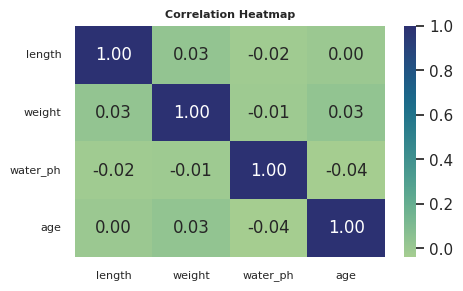

In [12]:
plt.figure(figsize=(5, 3))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap="crest", fmt=".2f")
plt.title("Correlation Heatmap", fontsize=8, weight="bold")
plt.xticks(fontsize=8, rotation=0)
plt.yticks(fontsize=8)
plt.show()

### Splitting the data into 2 sets

In the following code cell we are going to split the data into 2 sets which are `train` and `test`.

In [13]:
train, test = train_test_split(
    data, test_size=0.15, random_state=SEED
)

Next we are going to check the distribution of data in each set.

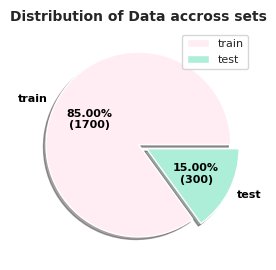

In [14]:
dist_sets = {'train': len(train), 'test': len(test)}
def fmt(x, total):
    return '{:.2f}%\n({:.0f})'.format(x, total*x/100)
plt.figure(figsize=(3, 3))
plt.title("Distribution of Data accross sets", fontsize=10, weight="bold")
plt.pie(
    dist_sets.values(), labels=dist_sets.keys(), autopct=lambda x: fmt(x, len(data)),
    textprops={'color': 'black', 'fontsize': 8, "weight": 'bold'}, radius=1, explode=[.0, .1],
    colors=PALETTES.gradient, shadow=True,
)
plt.legend(fontsize=8)
plt.show()

### Extracting features and Labels

In the next code cell we are going to extract features and labels from our dataset. We are going to have `Age` as our target label.

For both training and testing dataset. After extracting the labels we are going to transform them.

In [15]:
y_train = train.age.values
y_test = test.age.values

In [16]:
y_train[:2]

array([17.6,  6.1])

In [17]:
y_test[:2]

array([2.6, 1.1])

In the next code cell we are going to define the scaler for our labels.

In [18]:
scaler = StandardScaler()

In the next code cell we are then going to transform our labels using the `StandardScaler` created above.

In [19]:
def scale_labels(scaler, train, test):
    train = scaler.fit_transform(train.reshape(-1, 1))
    return train.reshape(-1), scaler.transform(test.reshape(-1, 1)).reshape(-1)

train_labels, test_labels = scale_labels(scaler, y_train, y_test)

In the following code cell we are going to remove `Age` so that we extract our features.

In [20]:
train.drop(columns=["age"], inplace=True)
test.drop(columns=["age"], inplace=True)

train.head(2)

,length,weight,habitat,water_ph,color,gender
1139,6.76,12.11,idlewater,6.2,red_and_white_bi_color,female
647,5.81,10.90,idlewater,7.5,white,female


We are going to use the `StandardScaler` to transform all the features in the dataframe for test and train sets.

In [21]:
categorical_colums = train.select_dtypes(include=['object']).columns
numerical_columns = train.select_dtypes(exclude=['object']).columns

scale_pipeline = Pipeline([
    ('standard_scaler', StandardScaler())
])
encode_scale_pipeline = Pipeline([
    ('ordinal', OrdinalEncoder()),
    ('scaler', StandardScaler())
])

ct = ColumnTransformer([
    ("scale pre-processing", scale_pipeline, numerical_columns),
    ("encode pre-processing", encode_scale_pipeline, categorical_colums)
])
train_features = ct.fit_transform(train)
test_features = ct.transform(test)

In [22]:
test_features[0]

array([ 0.74598784, -1.01617287, -1.22062025, -1.41213661, -1.55429673,
        1.04451946])

### Feature Impotance

In the following code cell we are going to create a function that will use the `XGBRegressor` algorithm to compute feature how important is for each feature in predicting `Age` of fish.  

In [23]:
def get_feature_impotance(train_features, train_labels, test_features, test_labels):
    xgb_model = xgb.XGBRegressor(
        base_score=0.5,
        booster='gbtree',
        n_estimators=1000,
        early_stopping_rounds=50,
        objective='reg:linear',
        max_depth=3,
        learning_rate=0.01
    )
    xgb_model.fit(
        train_features, train_labels,
        eval_set=[(train_features, train_labels), (test_features, test_labels)],
        verbose=100
   )
    return xgb_model.feature_importances_

Next we are going to get all the features importance array for the `Age`.

In [24]:
fi = get_feature_impotance(train_features, train_labels, test_features, test_labels)

[0]	validation_0-rmse:1.11556	validation_1-rmse:1.10165
[100]	validation_0-rmse:1.00022	validation_1-rmse:1.02064
[190]	validation_0-rmse:0.97774	validation_1-rmse:1.01859


Next we are going to create a dataframe that we are going to use to plot the feature importance, for `age`.

In [25]:
age_fi = pd.DataFrame(
    data=fi,
    index=train.columns,
    columns=['importance']
)
age_fi.head()

,importance
length,0.157722
weight,0.165035
habitat,0.165798
water_ph,0.141928
color,0.140878


In the following code cell we are going how important is each feature in predicting `Age`.

<Figure size 400x300 with 0 Axes>

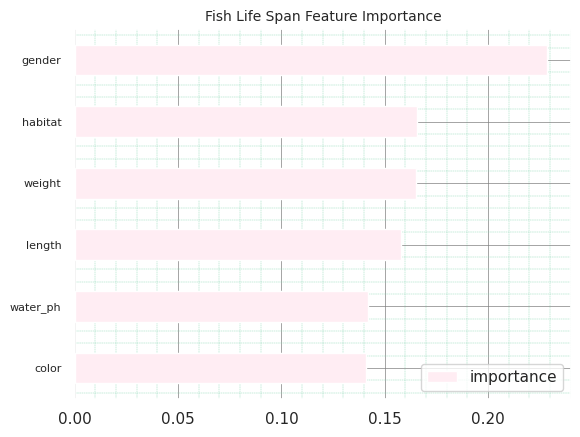

In [26]:

plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(4, 3))

age_fi.sort_values('importance').plot(kind='barh', color=PALETTES.gradient)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.yticks(fontsize=8)
plt.title('Fish Life Span Feature Importance', fontsize=10)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

> We can see that `Gender` is the most important feature in predicting life span of gold fishes.


### Model Selection

In the following code cell we are going to train `5` Regression Algorithm so that we can see which one will perform better among:

1. `Linear Regression (LR)`
2. `Decision Tree Regressor (DTR)`
3. `Random Forest Regressor (RFR)`
4. `Support Vector Regressor (SVR)`
5. `K-Neighbors Regressor (KNR)`


We are going to evaluate the models/algorithims so that we choose the best model for this task.

In [27]:
pipeline_lr = Pipeline([('lr_regressor', LinearRegression())])
pipeline_dt = Pipeline([ ('dt_regressor', DecisionTreeRegressor())])
pipeline_rf = Pipeline([('rf_regressor', RandomForestRegressor())])
pipeline_svr = Pipeline([('sv_regressor', SVR())])
pipeline_knn = Pipeline([('knn_regressor', KNeighborsRegressor())])

pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_svr, pipeline_knn]
pipe_dict = {0: 'LR', 1: 'DTR', 2: 'RFR', 3: "SVR", 4: 'KNR'}

def get_scores(X_train, y_train, X_test, y_test):
    for pipe in pipelines:
        pipe.fit(X_train, y_train)

    scores = []
    for i, model in enumerate(pipelines):
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mse =  mean_squared_error(y_test, y_pred)
        rscore = r2_score(y_test, y_pred)
        rmse = np.sqrt(mse)
        score = {
            'mae': mae, 'mse': mse, 'rmse': rmse,
            # 'r2-score': rscore,
            'regressor': pipe_dict[i]
        }
        scores.append(score)
    return scores

Next we are going to get the scores for `Age` and see which algorithm perfoms better.

In [28]:
scores = get_scores(train_features, train_labels, test_features, test_labels)
scores

[{'mae': 0.8666064221508588,
  'mse': 1.026320766889645,
  'rmse': np.float64(1.0130749068502511),
  'regressor': 'LR'},
 {'mae': 1.2171542350800022,
  'mse': 2.1713753605240846,
  'rmse': np.float64(1.4735587400996557),
  'regressor': 'DTR'},
 {'mae': 0.886607747874264,
  'mse': 1.0974095762177183,
  'rmse': np.float64(1.0475731841822404),
  'regressor': 'RFR'},
 {'mae': 0.8877980052696175,
  'mse': 1.0917399992987176,
  'rmse': np.float64(1.0448636271297407),
  'regressor': 'SVR'},
 {'mae': 0.9031181293990668,
  'mse': 1.1315785219049166,
  'rmse': np.float64(1.0637567964083317),
  'regressor': 'KNR'}]

In [29]:
scores_df  = pd.DataFrame(scores)
scores_df

,mae,mse,rmse,regressor
0,0.866606,1.026321,1.013075,LR
1,1.217154,2.171375,1.473559,DTR
2,0.886608,1.097410,1.047573,RFR
3,0.887798,1.091740,1.044864,SVR
4,0.903118,1.131579,1.063757,KNR


Next we are going to scale our metrics using the `MinMaxScaler` so that they can be plotted on the same axis with a minimum value of 0 and maximum value of 1.

In [30]:
def scale_scores(x, pipeline):
    return pipeline.fit_transform(x.values.reshape(-1, 1)).squeeze()

score_scale_pipeline = MinMaxScaler()

scores_df['mae'] = scale_scores(scores_df['mae'], score_scale_pipeline)
scores_df['mse'] = scale_scores(scores_df['mse'], score_scale_pipeline)
scores_df['rmse'] = scale_scores(scores_df['rmse'], score_scale_pipeline)
# scores_df['r2-score'] = scale_scores(scores_df['r2-score'], score_scale_pipeline)

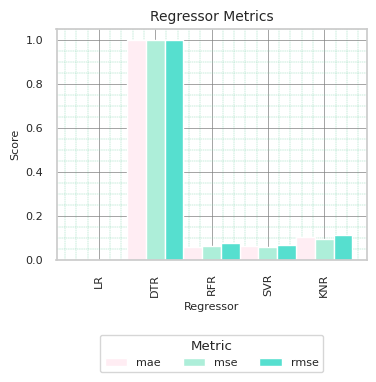

In [31]:
sns.set(font_scale=0.8)
sns.set_style("whitegrid")

scores_df.plot(
    x='regressor', kind='bar', stacked=False,
    fontsize=8, color=PALETTES.gradient, width=1, legend=True, figsize=(4, 3)
)
plt.title('Regressor Metrics', fontsize=10)
plt.xlabel('Regressor', fontsize=8)
plt.ylabel('Score', fontsize=8)
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=3,
    fontsize=8,
    title = "Metric"
)
plt.minorticks_on()
plt.show()

It seems like the `LR` model did well compared to othee regressors. From the above plot it is observed that the `LR` algorithm performs better than others, (with a larger `mse` less that other models of `1.026321`) compared to others, indicating that the `LR` algorithm found the best fit for the data.

Next we are going to use the  `GridSearchCV` to find the best parameters which are the best for this model.

In [32]:
def get_regressor(X_train, y_train):
    parameters = {}
    regressor = LinearRegression()
    gs = GridSearchCV(regressor, parameters)
    gs.fit(X_train, y_train)
    regressor = LinearRegression(**gs.best_params_)
    return gs.best_params_, regressor.fit(X_train, y_train)

Next we are going to get the best model for these features.

In [33]:
regressor_best_params, regressor = get_regressor(train_features, train_labels)

In [34]:
regressor_best_params

{}

### Regressor Evaluation
In the following code cell we are going to evaluate our regressors based on the test dataset.

In [35]:
def get_evaluation_scores(regressor, X_test, y_test):
    y_pred = regressor.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse =  mean_squared_error(y_test, y_pred)
    rscore = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)
    score = {
        'mae': mae, 'mse': mse, 'rmse': rmse,
        # 'r2-score': rscore
    }
    return score

In the following code cell we are going to make some display the metric scores based on the test dataset, for the `Decision Tree Regressor` algorithm.

In [36]:
scores = get_evaluation_scores(regressor, test_features, test_labels)
combined_data = []
for metric in scores:
    combined_data.append([
        metric.upper(),
        f"{scores[metric]:,.3f}"
    ])

headers = ['Metric', 'Score']
tabulate_data(headers, combined_data, title="Decision Tree Regressor Evaluation Metrics")

Decision Tree Regressor Evaluation Metrics
+--------+-------+
| Metric | Score |
+--------+-------+
| MAE    | 0.867 |
| MSE    | 1.026 |
| RMSE   | 1.013 |
+--------+-------+


### Making predictions.

Next we are going to predict `Life Span Prediction` using the data that we have in the test dataset.

In [37]:
def predict_age(data, labels):
    test_dataframe = data.reset_index(drop=True)
    features = ct.transform(test_dataframe)
    age = regressor.predict(features).reshape(-1, 1)
    result = pd.DataFrame({
        'age': labels,
        'Predicted age': scaler.inverse_transform(age).reshape(-1)
    })
    return result

predictions = predict_age(test, y_test)
predictions.head()

,age,Predicted age
0,2.6,13.707473
1,1.1,13.701946
2,17.6,14.101977
3,19.2,14.918497
4,14.2,15.520591


### Saving the best model

In the following code cell we are going to save the best model. Saving both model, ct and scaler in one file.

In [38]:
dump({
    "model": regressor,
    "column_transformer": ct,
    "scaler": scaler
}, "fish_lifespan_bundle.joblib")
print("Done!")

Done!


In [39]:
test.head(2)

,length,weight,habitat,water_ph,color,gender
1945,14.65,5.49,idlewater,6.3,black_and_orange,male
912,6.23,13.29,idlewater,7.3,yellow,male


In [40]:
test.columns

Index(['length', 'weight', 'habitat', 'water_ph', 'color', 'gender'], dtype='object')

In [41]:
test.dtypes

,0
length,float64
weight,float64
habitat,object
water_ph,float64
color,object
gender,object
